# Project 3: Part 3 Modeling

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
import datetime as dt
import numpy as np
import pickle
from tqdm import tqdm

%matplotlib inline

from sklearn import metrics

import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation

In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [155]:
from sklearn.metrics import confusion_matrix

In [156]:
with open("users.pkl", 'rb') as picklefile: 
    users = pickle.load(picklefile)

In [157]:
users = users.drop('id',axis = 1)

In [158]:
from sklearn.utils import resample

In [159]:
users.US.value_counts()

1    62376
0    26532
Name: US, dtype: int64

In [160]:
users.head()

,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_facebook,signup_method_google,signup_app_Moweb,signup_app_Web,signup_app_iOS,langues_en,diff_account_to_first_active,diff_account_to_first_booking,age,total_sessions,total_sessions_on_mac,total_sessions_on_windows,total_sessions_on_iphone,total_sessions_on_android,US,no_age_entered
0,1,0,0,0,0,0,1,0,1,475,-57,56.000000,0.0,0.0,0.0,0.0,0.0,1,0
1,1,0,0,1,0,0,1,0,1,764,278,42.000000,0.0,0.0,0.0,0.0,0.0,0,0
2,0,0,0,0,0,0,1,0,1,279,-208,41.000000,0.0,0.0,0.0,0.0,0.0,1,0
3,0,0,0,0,0,0,1,0,1,0,1,36.924928,0.0,0.0,0.0,0.0,0.0,1,1
4,1,0,0,0,0,0,1,0,1,0,3,46.000000,0.0,0.0,0.0,0.0,0.0,1,0


In [161]:
# Separate majority and minority classes
users_majority = users[users.US==1]
users_minority = users[users.US==0]
 
# Upsample minority class
users_minority_upsampled = resample(users_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=62376,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
users_upsampled = pd.concat([users_majority, users_minority_upsampled])
 
# Display new class counts
users_upsampled.US.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    62376
0    62376
Name: US, dtype: int64

In [162]:
y_upsampled = users_upsampled['US']
users_upsampled = users_upsampled.drop('US', axis = 1)

In [163]:
xtrain, xtest, ytrain, ytest = train_test_split(users_upsampled, y_upsampled, test_size=0.2,stratify = y)#, random_state = 1234)

In [176]:
ytest.value_counts()

1    12456
0     5326
Name: US, dtype: int64

In [164]:
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
   """
   This function prints and plots the confusion matrix.
   Normalization can be applied by setting `normalize=True`.
   """
   if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       print("Normalized confusion matrix")
   else:
       print('Confusion matrix, without normalization')

   print(cm)

   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)

   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

## KNN

In [165]:
normalizer = preprocessing.Normalizer()
xtrain_norm = normalizer.fit_transform(xtrain)
xtest_norm = normalizer.fit_transform(xtest)

In [119]:
k_range = list(range(1,31))
k_auc = []
for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(xtrain_norm, ytrain_norm)
    y_score = knn.predict_proba(xtest_norm)[:,1]
    fpr, tpr,_ = roc_curve(ytest_norm, y_score)
    roc_auc = auc(fpr, tpr)
    k_auc.append(roc_auc)
print(k_auc)

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

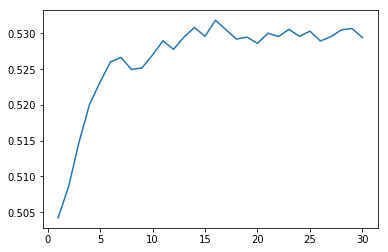

In [63]:
plt.plot(k_range, k_auc)
plt.savefig('knn_k_auc')

In [61]:
np.argmax(np.array(k_auc))

15

In [166]:
knn = KNeighborsClassifier(n_neighbors=16)
knn.fit(xtrain_norm, ytrain)
y_pred = knn.predict(xtest_norm)
y_score = knn.predict_proba(xtest_norm)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, knn.predict(xtest_norm)))
print(metrics.classification_report(ytest, knn.predict(xtest_norm)))
print(metrics.confusion_matrix(ytest,knn.predict(xtest_norm)))
print('ROC AUC:', roc_auc)

Accuracy: 0.679
             precision    recall  f1-score   support

          0       0.41      0.16      0.23      5326
          1       0.72      0.90      0.80     12456

avg / total       0.62      0.68      0.63     17782

[[  860  4466]
 [ 1244 11212]]
ROC AUC: 0.584489758437


In [167]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(xtrain_norm, ytrain)
y_pred = knn5.predict(xtest_norm)
y_score = knn5.predict_proba(xtest_norm)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, knn5.predict(xtest_norm)))
print(metrics.classification_report(ytest, knn5.predict(xtest_norm)))
print(metrics.confusion_matrix(ytest,knn5.predict(xtest_norm)))
print('ROC AUC:', roc_auc)

Accuracy: 0.674
             precision    recall  f1-score   support

          0       0.43      0.28      0.34      5326
          1       0.73      0.84      0.78     12456

avg / total       0.64      0.67      0.65     17782

[[ 1504  3822]
 [ 1975 10481]]
ROC AUC: 0.608763515995


## SVMs

### Linear

In [29]:
l_svm = SVC(kernel='linear')
l_svm.fit(xtrain_norm, ytrain_norm)
y_pred = l_svm.predict(xtest_norm)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest_norm, l_svm.predict(xtest_norm)))
print(metrics.classification_report(ytest_norm, l_svm.predict(xtest_norm)))
print(metrics.confusion_matrix(ytest_norm,l_svm.predict(xtest_norm)))

Accuracy: 0.702


/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      5307
          1       0.70      1.00      0.82     12475

avg / total       0.49      0.70      0.58     17782

[[    0  5307]
 [    0 12475]]


### RBF

In [ ]:
rbf_svm = SVC(kernel='rbf', gamma = 0.001)
rbf_svm.fit(xtrain_norm, ytrain_norm)
y_pred = svm.predict(xtest_norm)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest_norm, rbf_svm.predict(xtest_norm)))
print(metrics.classification_report(ytest_norm, rbf_svm.predict(xtest_norm)))
print(metrics.confusion_matrix(ytest_norm,rbf_svm.predict(xtest_norm)))

## Logistic Regression

In [168]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(xtrain, ytrain)
y_pred = lr.predict(xtest)
y_score = lr.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)
    

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, lr.predict(xtest)))
print(metrics.classification_report(ytest, lr.predict(xtest)))
print(metrics.confusion_matrix(ytest,lr.predict(xtest)))
print('ROC AUC:', roc_auc)

Accuracy: 0.558
             precision    recall  f1-score   support

          0       0.32      0.44      0.37      5326
          1       0.72      0.61      0.66     12456

avg / total       0.60      0.56      0.57     17782

[[2357 2969]
 [4899 7557]]
ROC AUC: 0.537473498905


100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


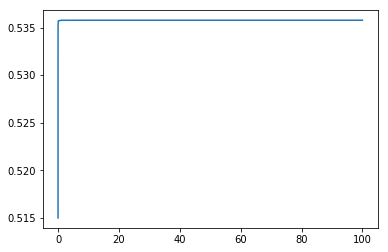

In [96]:
c_range = [0.00001,0.001, 0.01, 0.1, 1, 10,100]
c_auc = []

for c in tqdm(c_range):

    lr = LogisticRegression(class_weight = 'balanced', C = c)
    lr.fit(xtrain, ytrain)
    y_pred = lr.predict(xtest)
    y_score = lr.predict_proba(xtest)[:,1]
    fpr, tpr,_ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    c_auc.append(roc_auc)
    

plt.plot(c_range, c_auc)
plt.savefig('c_auc')

In [97]:
np.argmax(np.array(c_auc))

6

In [98]:
lr = LogisticRegression(class_weight = 'balanced', C = 100)
lr.fit(xtrain, ytrain)
y_pred = lr.predict(xtest)
y_score = lr.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)
    

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, lr.predict(xtest)))
print(metrics.classification_report(ytest, lr.predict(xtest)))
print(metrics.confusion_matrix(ytest,lr.predict(xtest)))
print('ROC AUC:', roc_auc)

Accuracy: 0.546
             precision    recall  f1-score   support

          0       0.32      0.47      0.38      5286
          1       0.72      0.58      0.64     12496

avg / total       0.60      0.55      0.56     17782

[[2470 2816]
 [5253 7243]]
ROC AUC: 0.535767260885


## Random Forests

Accuracy: 0.746
             precision    recall  f1-score   support

          0       0.62      0.38      0.47      5326
          1       0.77      0.90      0.83     12456

avg / total       0.73      0.75      0.72     17782

ROC AUC: 0.697332545219
Confusion matrix, without normalization
[[ 2011  3315]
 [ 1210 11246]]


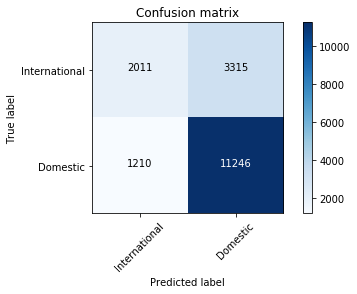

In [178]:
rf = RandomForestClassifier(n_estimators = 80)# class_weight = 'balanced')
rf.fit(xtrain, ytrain)
y_pred = rf.predict(xtest)
y_score = rf.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, rf.predict(xtest)))
print(metrics.classification_report(ytest, rf.predict(xtest)))
print('ROC AUC:', roc_auc)
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['International', 'Domestic'])

In [203]:
n_range = list(range(10,100))
n_up_auc = []
for n in tqdm(n_range):
    rf = RandomForestClassifier(n_estimators = n)#class_weight = 'balanced')
    rf.fit(xtrain, ytrain)
    y_score = rf.predict_proba(xtest)[:,1]
    fpr, tpr,_ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    n_up_auc.append(roc_auc)
print(n_up_auc)


  7%|▋         | 6/90 [00:05<01:14,  1.13it/s]
Exception in thread Thread-14:
Traceback (most recent call last):
  File "/Users/emilygeller/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/emilygeller/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/emilygeller/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 90/90 [05:45<00:00,  3.84s/it]

[0.68220013605740148, 0.6862965795917737, 0.68337861098388508, 0.68365341465037044, 0.68626902591996419, 0.68623582699504415, 0.68803799281038092, 0.68615803283771948, 0.68710425131995767, 0.68942055081618803, 0.68943973863097785, 0.68697883903699619, 0.68947150168161286, 0.68814061247837321, 0.68984706593675282, 0.68934740435720743, 0.68692098086053643, 0.68881933513851445, 0.68993151045918799, 0.68808258048555249, 0.68960832538652483, 0.68977059429521703, 0.6908077565203391, 0.68901277007642825, 0.68758941812645591, 0.68952740253470501, 0.69140642541046471, 0.69036620250594527, 0.69171672540072637, 0.68834542860930548, 0.68814934108258052, 0.69142639917749482, 0.69174276006868674, 0.68884778056382734, 0.69107642371356359, 0.69083094966866154, 0.69197353529524841, 0.69194879291414479, 0.68970272278492617, 0.69080847445748172, 0.69080313149369421, 0.69129624850939242, 0.69128127763066116, 0.69098593340466452, 0.69198584602793578, 0.69213479153470781, 0.69163577987720726, 0.691135075399

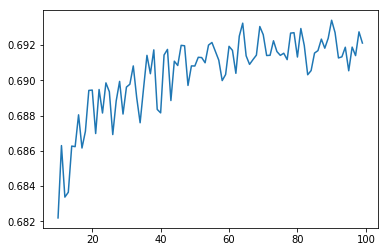

In [204]:
plt.plot(n_range, n_up_auc)
plt.savefig('n_up_auc')

In [205]:
np.argmax(np.array(n_up_auc))

80

Accuracy: 0.700
             precision    recall  f1-score   support

          0       0.50      0.55      0.52      5326
          1       0.80      0.76      0.78     12456

avg / total       0.71      0.70      0.70     17782

ROC AUC: 0.708928647012
Confusion matrix, without normalization
[[2916 2410]
 [2928 9528]]


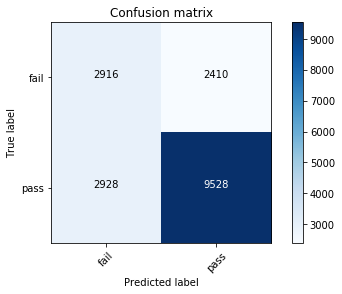

In [170]:
rf_64 = RandomForestClassifier(max_depth = 40,n_estimators = 80,class_weight = 'balanced', random_state = 123)
rf_64.fit(xtrain, ytrain)
y_pred = rf_64.predict(xtest)
y_score = rf_64.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, rf_64.predict(xtest)))
print(metrics.classification_report(ytest, rf_64.predict(xtest)))
print('ROC AUC:', roc_auc)
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['fail', 'pass'])

In [207]:
features = pd.DataFrame()
features['importances'] = rf_64.feature_importances_
features['features'] = xtrain_up.columns
features.sort_values('importances',ascending = False)

,importances,features
9,0.360951,diff_account_to_first_booking
10,0.247473,age
11,0.151644,total_sessions
12,0.076642,total_sessions_on_mac
13,0.063506,total_sessions_on_windows
14,0.031262,total_sessions_on_iphone
3,0.019725,signup_method_facebook
0,0.015077,gender_FEMALE
1,0.014908,gender_MALE
6,0.004819,signup_app_Web


In [180]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(xtrain_up.columns)
dot_data = StringIO()  
export_graphviz(rf_64, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## Naive Bayes

### Gaussian

Accuracy: 0.386
             precision    recall  f1-score   support

          0       0.31      0.86      0.46      5326
          1       0.75      0.18      0.30     12456

avg / total       0.62      0.39      0.34     17782

Confusion matrix, without normalization
[[2916 2410]
 [2928 9528]]


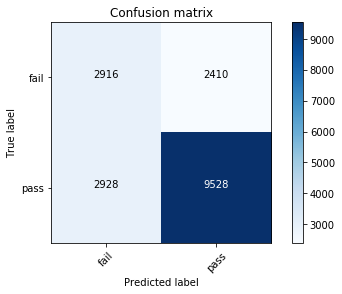

In [171]:
nb_g = naive_bayes.GaussianNB()
nb_g.fit(xtrain, ytrain)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, nb_g.predict(xtest)))
print(metrics.classification_report(ytest, nb_g.predict(xtest)))
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['fail', 'pass'])

### Bernoulli

Accuracy: 0.700
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      5326
          1       0.70      1.00      0.82     12456

avg / total       0.49      0.70      0.58     17782

Confusion matrix, without normalization
[[2916 2410]
 [2928 9528]]


/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


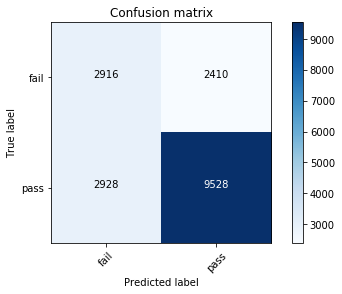

In [172]:
nb_b = naive_bayes.BernoulliNB()
nb_b.fit(xtrain, ytrain)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, nb_b.predict(xtest)))
print(metrics.classification_report(ytest, nb_b.predict(xtest)))
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['fail', 'pass'])

## Roc Curves

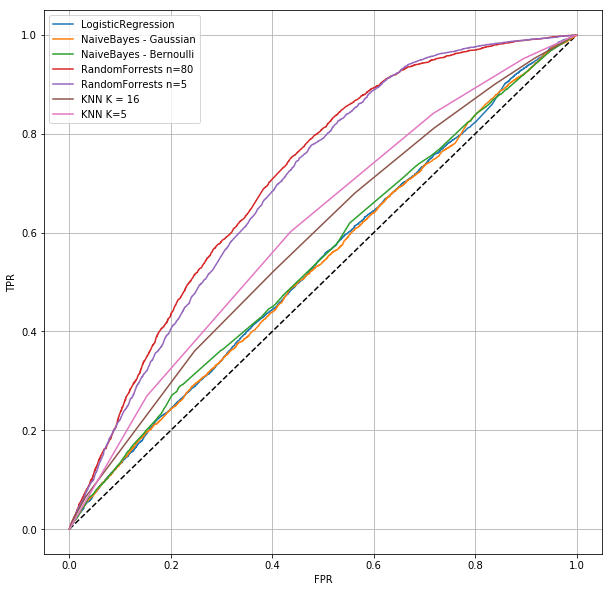

In [173]:
# What about ROC ? 

from sklearn.metrics import roc_curve, auc


lr_score=lr.predict_proba(xtest)[:,1]
nb_g_score = nb_g.predict_proba(xtest)[:,1]
nb_b_score = nb_b.predict_proba(xtest)[:,1]
rf_64_score = rf_64.predict_proba(xtest)[:,1]
rf_score = rf.predict_proba(xtest)[:,1]
knn_score = knn.predict_proba(xtest_norm)[:,1]
knn5_score = knn5.predict_proba(xtest_norm)[:,1]
#l_svm_score = l_svm.predict_proba(xtest)[:,1]

lr_fpr, lr_tpr,_ = roc_curve(ytest, lr_score)
nb_g_fpr, nb_g_tpr,_ = roc_curve(ytest, nb_g_score)
nb_b_fpr, nb_b_tpr,_ = roc_curve(ytest, nb_b_score)
rf_64_fpr, rf_64_tpr,_ = roc_curve(ytest, rf_64_score)
rf_fpr, rf_tpr,_ = roc_curve(ytest, rf_score)
knn_fpr, knn_tpr,_ = roc_curve(ytest, knn_score)
knn5_fpr, knn5_tpr,_ = roc_curve(ytest, knn5_score)
#l_svm_fpr, l_svm_tpr,_ = roc_curve(ytest, l_svm_score)
#roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10,10))
plt.subplot(1,1,1)
# Plotting our Baseline..
plt.plot([0,1],[0,1], 'k--')

plt.plot(lr_fpr,lr_tpr, label = 'LogisticRegression')
plt.plot(nb_g_fpr,nb_g_tpr, label = 'NaiveBayes - Gaussian')
plt.plot(nb_b_fpr,nb_b_tpr, label = 'NaiveBayes - Bernoulli')
plt.plot(rf_64_fpr,rf_64_tpr, label = 'RandomForrests n=80')
plt.plot(rf_fpr,rf_tpr, label = 'RandomForrests n=5')
plt.plot(knn_fpr,knn_tpr, label = 'KNN K = 16')
plt.plot(knn5_fpr,knn5_tpr, label = 'KNN K=5')
#plt.plot(l_svm_fpr,l_svm_tpr, label = 'SVM-Linear')

plt.legend()
plt.grid(True)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.savefig('RocCurve')